In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import glob
import os

from matplotlib import pyplot as plt
from sklearn.cluster import SpectralCoclustering
import itertools
import matplotlib
import calpgs
from admix.data import pval2chisq, zsc2pval
import sys
from scipy import stats
from calpgs import compare_values

sys.path.append("../r2-diff/")

from utils import load_r2_result, plot_heatmap, plot_heatmap2

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

# Load meta data

In [2]:
DATA_DIR = "../compile-data/out/per-trait-info/"
DATA_URL = "../r2-diff/data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

ALL_TRAIT_LIST = trait_map.keys()
MAIN_TRAIT_LIST = df_display.id.values
MAIN_COVAR_LIST = covar_map.keys()

# Load data

In [3]:
dict_df_sigma = dict()
for method in ["marginal", "joint", "joint+slope"]:
    for group in ["white", "other"]:
        dict_df_sigma[method, group] = pd.read_csv(
            f"out/fit-summary/{method}-{group}.gamma.tsv", sep="\t", index_col=0
        )

dict_df_slope = dict()
dict_df_r2 = dict()

for group in ["white", "other"]:
    dict_df_slope[group] = pd.read_csv(
        f"out/fit-summary/joint+slope-{group}.slope.tsv", sep="\t", index_col=0
    )
    dict_df_r2[group] = load_r2_result("../r2-diff/out/", group)[3].loc[
        :, MAIN_TRAIT_LIST
    ]

# Overview of statistics

## Consistency between $\Delta R^2$ and $\beta_\sigma$ 

In [18]:
# annotate_list = [("SEX", "log_BMI"), ("SEX", "height"), ("glasses", "myopia")]
annotate_list = []

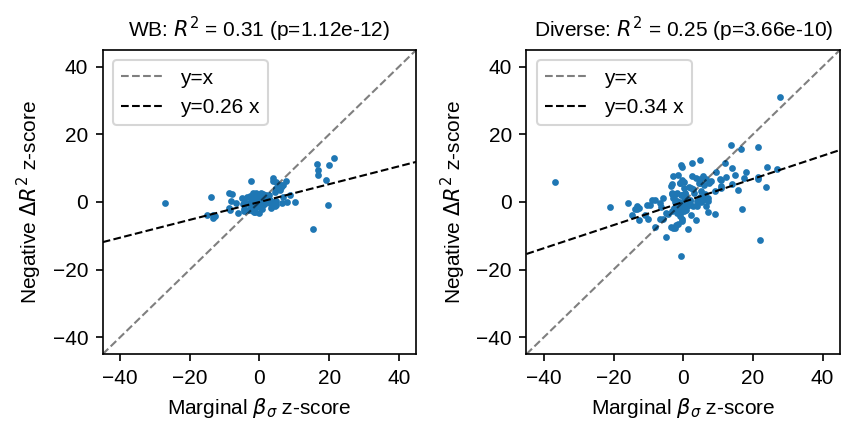

In [55]:
fig, axes = plt.subplots(figsize=(5.8, 3), dpi=150, ncols=2)

for i, group in enumerate(["white", "other"]):
    ax = axes[i]

    df_r2 = dict_df_r2[group]
    df_sigma = dict_df_sigma["marginal", group]
    df_slope = dict_df_slope[group]

    tmp_covar_list = list(set(df_slope.index) & set(df_r2.index))
    df_r2 = (-1) * df_r2.loc[tmp_covar_list, MAIN_TRAIT_LIST]
    df_sigma = df_sigma.loc[tmp_covar_list, MAIN_TRAIT_LIST]
    df_slope = df_slope.loc[tmp_covar_list, MAIN_TRAIT_LIST]

    x, y = df_sigma.values.flatten(), df_r2.values.flatten()
    notnan_idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[notnan_idx], y[notnan_idx]
    compare_values(
        x=x,
        y=y,
        xlabel=r"Marginal $\beta_\sigma$ z-score",
        ylabel="Negative $\Delta R^2$ z-score",
        ax=ax,
    )
    for annot in annotate_list:
        ax.annotate(
            covar_map[annot[0]] + "-" + trait_map[annot[1]],
            xy=(df_sigma.loc[annot], df_r2.loc[annot]),
            xytext=(0, 5),
            color="red",
            textcoords="offset points",
            ha="center",
        )

    name = {"white": "WB", "other": "Diverse"}[group]
    ax.set_title(
        f"{name}: $R^2$ = {stats.pearsonr(x, y)[0] ** 2:.2g} (p={stats.pearsonr(x, y)[1]:.3g})",
        fontsize=10,
    )
for ax in axes:
    ax.set_xlim(-45, 45)
    ax.set_ylim(-45, 45)
fig.tight_layout()
plt.savefig("results/beta-sigma-r2-consistency.pdf", bbox_inches="tight")

# Consistency between joint / joint+slope

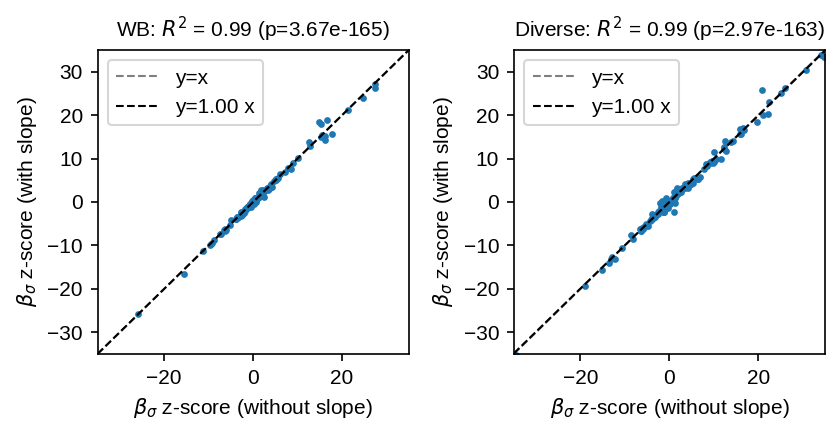

In [54]:
fig, axes = plt.subplots(figsize=(5.7, 3), dpi=150, ncols=2)
for i, group in enumerate(["white", "other"]):
    ax = axes[i]
    df_sigma1 = dict_df_sigma["joint", group]
    df_sigma2 = dict_df_sigma["joint+slope", group]

    tmp_covar_list = list(set(df_sigma1.index) & set(df_sigma1.index))
    df_sigma1 = df_sigma1.loc[tmp_covar_list, MAIN_TRAIT_LIST]
    df_sigma2 = df_sigma2.loc[tmp_covar_list, MAIN_TRAIT_LIST]

    x, y = df_sigma1.values.flatten(), df_sigma2.values.flatten()
    notnan_idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[notnan_idx], y[notnan_idx]
    compare_values(
        x=x,
        y=y,
        xlabel=r"$\beta_\sigma$ z-score (without slope)",
        ylabel=r"$\beta_\sigma$ z-score (with slope)",
        ax=ax,
    )

    name = {"white": "WB", "other": "Diverse"}[group]
    ax.set_title(
        f"{name}: $R^2$ = {stats.pearsonr(x, y)[0] ** 2:.2g} (p={stats.pearsonr(x, y)[1]:.3g})",
        fontsize=10,
    )

for ax in axes:
    ax.set_xlim(-35, 35)
    ax.set_ylim(-35, 35)

fig.tight_layout()
plt.savefig("results/beta-sigma-slope-fitting.pdf", bbox_inches="tight")

# Consistency of coefficients between populations

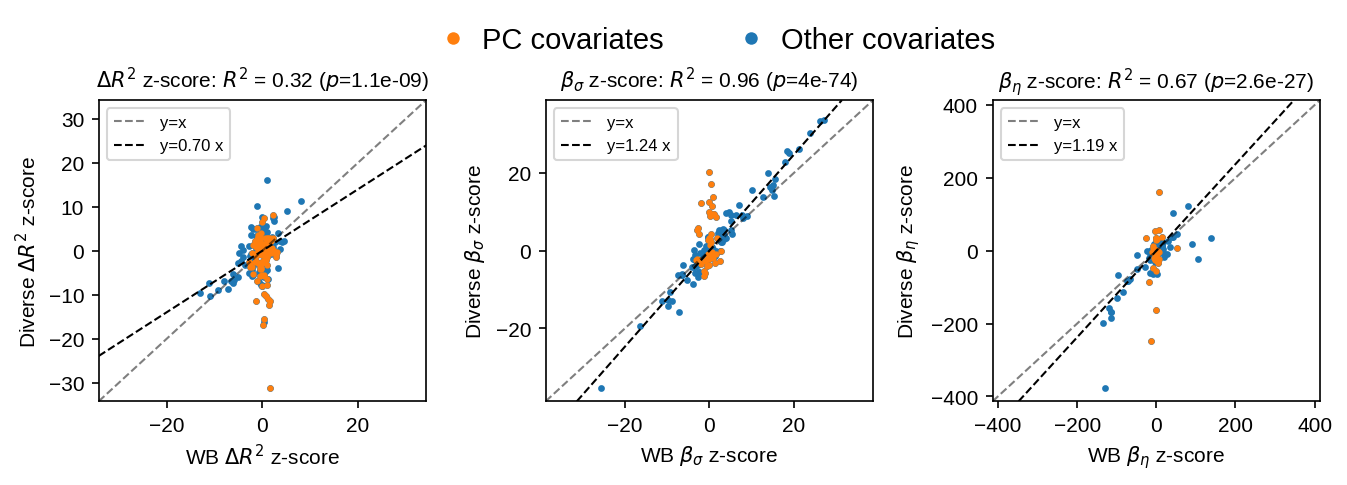

In [53]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(figsize=(9, 3), dpi=150, ncols=3)

dict_label = {
    "var": r"$\beta_\sigma$ z-score",
    "slope": r"$\beta_\eta$ z-score",
    "r2": r"$\Delta R^2$ z-score",
}
for i, name in enumerate(["r2", "var", "slope"]):
    ax = axes[i]
    if name == "var":
        df1 = dict_df_sigma["joint+slope", "white"]
        df2 = dict_df_sigma["joint+slope", "other"]
    elif name == "slope":
        df1 = dict_df_slope["white"]
        df2 = dict_df_slope["other"]
    elif name == "r2":
        df1 = dict_df_r2["white"]
        df2 = dict_df_r2["other"]
    else:
        raise NotImplementedError

    if i == 1:
        legend_elements = [
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor="C1",
                label="PC covariates",
                markersize=7,
            ),
            Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor="C0",
                label="Other covariates",
                markersize=7,
            ),
        ]
        scatter_legend = ax.legend(
            handles=legend_elements,
            bbox_to_anchor=(0.5, 1.2),
            loc="center",
            frameon=False,
            handletextpad=0.02,
            fontsize=14,
            ncol=2,
        )

    x, y = df1.values.flatten(), df2.values.flatten()
    notnan_idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[notnan_idx], y[notnan_idx]

    compare_values(
        x=x,
        y=y,
        xlabel=fr"WB {dict_label[name]}",
        ylabel=fr"Diverse {dict_label[name]}",
        ax=ax,
    )
    ax.legend(loc="upper left", fontsize=8)

    # plot PC
    ax.scatter(
        df1.loc[df1.index.str.startswith("PC"), :],
        df2.loc[df2.index.str.startswith("PC"), :],
        s=4,
        label="PC covariates",
    )
    # get values other than PC
    R2_exclude_PC = True
    if R2_exclude_PC:
        x, y = (
            df1.loc[~df1.index.str.startswith("PC"), :].values.flatten(),
            df2.loc[~df2.index.str.startswith("PC"), :].values.flatten(),
        )
        notnan_idx = (~np.isnan(x)) & (~np.isnan(y))
        x, y = x[notnan_idx], y[notnan_idx]

    ax.set_title(
        f"{dict_label[name]}: $R^2$ = {stats.pearsonr(x, y)[0] ** 2:.2g} ($p$={stats.pearsonr(x, y)[1]:.2g})",
        fontsize=10,
    )

axes[1].add_artist(scatter_legend)
fig.tight_layout()
plt.savefig("results/wb-diverse-param-consistency.pdf", bbox_inches="tight")
fig.show()

## Parameteric test

In [8]:
for group in ["white", "other"]:
    df_sigma = dict_df_sigma["joint+slope", group] * (-1)

    display(
        df_sigma.loc[MAIN_COVAR_LIST, MAIN_TRAIT_LIST]
        .rename(index=covar_map, columns=trait_map)
        .style.background_gradient(axis=None, vmin=-5, vmax=5, cmap="bwr")
        .format(precision=2)
        .set_caption("Group: " + group)
    )

,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Diastolic BP,Height,BMI,Neuroticism,Edu years
Age,-18.94,-18.03,-13.85,4.17,0.02,2.23,-5.43,2.45,8.82,11.21,3.76
Sex,-4.03,-4.74,-6.96,-3.10,-7.90,-0.10,-3.09,-10.03,25.77,2.75,0.73
PC1,-0.94,-0.56,-0.29,0.07,-0.97,-0.53,2.10,0.12,0.17,0.01,0.47
PC2,0.26,-0.60,1.13,-0.03,-1.55,-0.87,-0.39,-1.48,-1.08,1.09,0.01
Smoking,-3.40,-2.68,-3.54,-6.34,-3.95,1.08,0.04,0.41,0.19,-3.48,-0.73
Alcohol,1.62,1.19,0.51,3.40,1.60,0.40,-1.22,-0.20,5.27,1.35,-0.90
BMI,-14.28,-15.18,-15.64,9.70,16.51,1.21,-1.06,-1.58,nan,0.52,-2.13
Wear glasses,0.63,0.28,0.31,2.50,3.54,-18.34,2.23,0.74,-3.19,-2.21,0.85
Income,6.57,6.50,7.38,6.21,3.48,-2.01,2.78,3.46,9.92,9.34,7.30
Deprivation index,-2.66,-2.10,-2.84,-5.21,-3.33,-0.70,0.39,-5.08,-15.44,-5.19,2.48


,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Diastolic BP,Height,BMI,Neuroticism,Edu years
Age,-25.12,-22.95,-20.07,4.08,1.21,3.01,-4.18,5.59,13.09,13.10,4.26
Sex,-9.63,-9.99,-11.66,-2.11,-8.31,1.06,-5.25,-15.58,35.29,3.58,1.99
PC1,-13.93,-11.43,-17.11,-9.99,-9.43,1.00,-12.22,-20.29,2.25,3.65,2.08
PC2,0.74,0.40,2.71,-8.93,-8.64,1.93,1.27,0.89,-9.45,5.76,-3.31
Smoking,-4.08,-3.30,-5.23,-9.28,-3.30,0.02,-2.06,1.67,-2.95,-2.89,-0.90
Alcohol,1.90,1.31,2.16,2.38,0.48,-3.48,0.31,-0.79,7.62,1.10,-0.33
BMI,-16.54,-16.88,-18.47,12.77,19.36,-0.15,0.31,-0.02,nan,-0.54,-3.75
Wear glasses,0.28,-0.13,-0.83,-1.78,-0.25,-25.66,0.53,-1.26,-4.37,-5.24,0.92
Income,6.26,6.05,6.32,3.67,5.72,-4.56,6.75,4.23,14.13,10.68,15.75
Deprivation index,-2.36,-3.20,-2.56,-7.58,-5.53,0.60,-3.54,-9.15,-13.99,-5.37,5.45


## R2 difference

In [9]:
for group in ["white", "other"]:

    df_r2 = dict_df_r2[group]

    display(
        df_r2.loc[MAIN_COVAR_LIST, MAIN_TRAIT_LIST]
        .rename(index=covar_map, columns=trait_map)
        .style.background_gradient(axis=None, vmin=-5, vmax=5, cmap="bwr")
        .format(precision=2)
        .set_caption("Group: " + group)
    )

trait,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Diastolic BP,Height,BMI,Neuroticism,Edu years
group,,,,,,,,,,,
Age,-13.16,-11.04,-11.26,-1.27,0.94,-0.22,-5.13,-1.98,-2.80,2.27,-6.21
Sex,-7.21,-5.84,-6.07,-2.15,-5.11,0.71,-2.89,0.07,0.37,-1.67,-1.65
PC1,1.27,0.79,1.32,0.39,-1.44,0.88,0.37,1.63,0.14,1.00,1.52
PC2,-0.96,-0.26,-0.96,-0.50,0.25,-1.29,-0.04,-1.09,-0.43,1.06,0.41
Smoking,-4.87,-4.01,-4.46,-1.45,1.01,-0.40,-2.31,-0.16,-1.04,0.48,0.74
Alcohol,2.34,2.44,2.19,1.06,0.52,-0.46,1.00,-1.22,-2.40,-2.39,0.85
BMI,-9.34,-7.99,-6.54,1.71,3.76,-0.41,-6.23,-1.87,5.14,-0.30,-2.21
Wear glasses,-4.48,-3.67,-3.98,0.62,2.68,8.02,-0.29,1.95,0.44,1.38,-2.60
Income,4.62,4.12,3.73,0.37,-1.38,1.70,0.62,0.24,-1.37,-0.21,3.22


trait,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Diastolic BP,Height,BMI,Neuroticism,Edu years
group,,,,,,,,,,,
Age,-9.71,-10.36,-7.27,4.89,1.77,0.16,-2.81,4.91,1.06,0.94,-5.37
Sex,-8.74,-6.66,-7.35,-4.48,-6.10,0.34,-5.06,2.19,-5.90,-2.29,-2.35
PC1,-10.97,-10.38,-12.41,-15.60,-11.40,-7.72,-9.91,-31.13,-16.92,-6.39,-11.47
PC2,3.06,1.69,2.45,-4.06,-5.69,-1.13,-2.57,-6.90,-3.47,-1.32,-0.47
Smoking,-0.51,0.07,1.08,3.42,1.17,2.39,-0.86,7.65,1.01,0.84,5.56
Alcohol,7.68,6.81,7.33,4.27,2.14,5.46,2.66,10.26,5.45,3.60,15.99
BMI,-8.93,-6.96,-6.79,-0.70,0.41,-0.33,-6.77,-5.49,9.13,-0.78,-5.73
Wear glasses,-2.31,-3.15,-1.45,3.24,2.00,11.31,-0.11,3.14,2.66,1.05,-1.11
Income,2.09,1.90,2.12,1.39,0.26,2.99,3.71,5.10,1.52,0.84,3.91


In [10]:
for group in ["white", "other"]:

    df_slope = dict_df_slope[group]

    display(
        df_slope.loc[MAIN_COVAR_LIST, MAIN_TRAIT_LIST]
        .rename(index=covar_map, columns=trait_map)
        .style.background_gradient(axis=None, vmin=-5, vmax=5, cmap="bwr")
        .format(precision=2)
        .set_caption("Group: " + group)
    )

,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Diastolic BP,Height,BMI,Neuroticism,Edu years
Age,-113.87,-134.79,-115.65,-49.13,-8.24,3.10,-114.85,2.89,-96.19,2.04,-29.36
Sex,-99.90,-119.59,-85.19,138.62,-14.74,1.16,-8.68,-8.06,-128.79,22.63,89.99
PC1,-2.85,-3.00,-1.56,7.11,-1.03,-0.39,-7.62,-12.56,0.00,2.13,-1.12
PC2,-1.58,-1.28,-1.76,1.54,-1.44,0.77,-10.34,14.67,-8.23,4.13,-2.49
Smoking,-3.84,-2.70,-3.10,-15.00,0.50,1.93,-9.81,-23.32,27.34,-0.34,9.43
Alcohol,6.61,7.44,4.71,-4.18,2.25,-0.59,-1.04,-3.20,11.47,-1.35,7.22
BMI,-72.46,-73.38,-67.02,3.58,-6.45,-0.82,-48.60,39.69,nan,5.15,10.06
Wear glasses,1.94,1.33,2.73,-12.95,3.03,79.72,-9.66,-1.48,-2.66,-1.70,-0.85
Income,13.93,13.33,13.20,-17.60,1.97,-1.31,28.43,52.40,43.05,-7.72,16.73
Deprivation index,-10.73,-10.43,-10.54,-6.31,1.53,1.19,-7.78,-15.10,5.00,-1.83,14.51


,LDL,Cholesterol,ApoB,WBC,CRP,Myopia diagnosis,Diastolic BP,Height,BMI,Neuroticism,Edu years
Age,-169.37,-198.31,-168.85,-12.38,-12.65,10.53,-183.63,-63.81,-65.67,-10.11,-45.76
Sex,-130.74,-158.19,-112.56,35.11,-20.06,-1.27,-23.17,-63.91,-375.93,-8.70,18.35
PC1,-23.94,-25.23,-18.03,161.66,-4.79,0.10,8.38,-247.44,-162.73,-8.42,-56.75
PC2,34.03,35.02,29.14,31.52,0.61,-1.67,-3.86,36.49,12.17,-0.13,55.36
Smoking,-2.05,-1.67,1.27,-9.62,-0.29,-0.31,-2.50,-1.38,-9.24,13.80,-2.01
Alcohol,15.40,16.66,15.48,-16.36,1.53,2.48,16.95,6.63,29.21,6.43,11.48
BMI,-82.50,-83.78,-79.01,29.90,-1.37,1.15,-49.05,37.31,nan,0.43,-3.02
Wear glasses,-12.04,-13.09,-12.34,0.73,-1.36,122.15,-7.54,16.94,-8.42,5.71,-6.37
Income,13.75,14.36,11.91,-21.24,1.58,1.57,26.01,44.93,36.57,-16.70,5.89
Deprivation index,-15.63,-15.69,-12.34,19.35,-0.57,0.82,-18.17,-24.63,-23.03,0.31,-4.38
